### Import the necessary modules.

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

### Import the filtered dataset.

In [144]:
df = pd.read_csv('baseline_df.csv')

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391721 entries, 0 to 391720
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            391721 non-null  int64  
 1   WEATHER_CONDITION     391721 non-null  object 
 2   LIGHTING_CONDITION    391721 non-null  object 
 3   ROADWAY_SURFACE_COND  391719 non-null  object 
 4   DAMAGE                391719 non-null  object 
 5   CRASH_HOUR            391719 non-null  float64
 6   CRASH_DAY_OF_WEEK     391719 non-null  float64
 7   CRASH_MONTH           391719 non-null  float64
 8   MOST_SEVERE_INJURY    391224 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 26.9+ MB


# EDA

### Explore the UNIQUE VALUES of each categorical column.

In [146]:
print("Unique values in the 'WEATHER_CONDITION' column:")
print(df['WEATHER_CONDITION'].value_counts())

print("\nUnique values in the 'LIGHTING_CONDITION' column:")
print(df['LIGHTING_CONDITION'].value_counts())

print("\nUnique values in the 'ROADWAY_SURFACE_COND' column:")
print(df['ROADWAY_SURFACE_COND'].value_counts())

print("\nUnique values in the 'DAMAGE' column:")
print(df['DAMAGE'].value_counts())

print("\nUnique values in the 'MOST_SEVERE_INJURY' column:")
print(df['MOST_SEVERE_INJURY'].value_counts())

Unique values in the 'WEATHER_CONDITION' column:
WEATHER_CONDITION
CLEAR                     307726
RAIN                       35638
UNKNOWN                    17971
SNOW                       15234
CLOUDY/OVERCAST            12284
OTHER                       1252
FOG/SMOKE/HAZE               746
SLEET/HAIL                   695
SEVERE CROSS WIND GATE        85
FREEZING RAIN/DRIZZLE         78
BLOWING SNOW                  12
Name: count, dtype: int64

Unique values in the 'LIGHTING_CONDITION' column:
LIGHTING_CONDITION
DAYLIGHT                  258086
DARKNESS, LIGHTED ROAD     80374
DARKNESS                   19256
UNKNOWN                    15400
DUSK                       11817
DAWN                        6786
DAYLIGH{                       2
Name: count, dtype: int64

Unique values in the 'ROADWAY_SURFACE_COND' column:
ROADWAY_SURFACE_COND
DRY                290363
WET                 55177
UNKNOWN             27060
SNOW OR SLUSH       15247
ICE                  2945
OTHER        

In [147]:
# Replace the incorrect 'LIGHTING_CONDITION' value with the correct value
df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].replace('DAYLIGH{', 'DAYLIGHT')

# Verify the corrected value
print(df['LIGHTING_CONDITION'].unique())

['DAYLIGHT' 'UNKNOWN' 'DAWN' 'DARKNESS, LIGHTED ROAD' 'DARKNESS' 'DUSK']


### Explore the UNIQUE VALUES of each discrete numerical column.

In [148]:
print("Unique values in the 'CRASH_HOUR' column:")
print(df['CRASH_HOUR'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_DAY_OF_WEEK' column:")
print(df['CRASH_DAY_OF_WEEK'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_MONTH' column:")
print(df['CRASH_MONTH'].value_counts().sort_index())

Unique values in the 'CRASH_HOUR' column:
CRASH_HOUR
0.0      7169
1.0      6386
2.0      5493
3.0      4452
4.0      4130
5.0      5270
6.0      9052
7.0     18395
8.0     22587
9.0     18969
10.0    17802
11.0    19607
12.0    22904
13.0    23394
14.0    26591
15.0    30295
16.0    30454
17.0    30099
18.0    24749
19.0    17359
20.0    13323
21.0    12430
22.0    11515
23.0     9294
Name: count, dtype: int64

Unique values in the 'CRASH_DAY_OF_WEEK' column:
CRASH_DAY_OF_WEEK
1.0    46430
2.0    54400
3.0    56914
4.0    55661
5.0    56560
6.0    64063
7.0    57691
Name: count, dtype: int64

Unique values in the 'CRASH_MONTH' column:
CRASH_MONTH
1.0     33240
2.0     30847
3.0     34897
4.0     35135
5.0     39500
6.0     39798
7.0     29355
8.0     27960
9.0     27111
10.0    28542
11.0    29745
12.0    35589
Name: count, dtype: int64


In [149]:
# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Print the columns with null values
print(null_counts[null_counts > 0])

ROADWAY_SURFACE_COND      2
DAMAGE                    2
CRASH_HOUR                2
CRASH_DAY_OF_WEEK         2
CRASH_MONTH               2
MOST_SEVERE_INJURY      497
dtype: int64


In [150]:
# Drop rows with null values
df = df.dropna()

# Print the updated DataFrame shape
print(df.shape)


(391224, 9)


### Make countplots for the UNIQUE values of each categorical column.

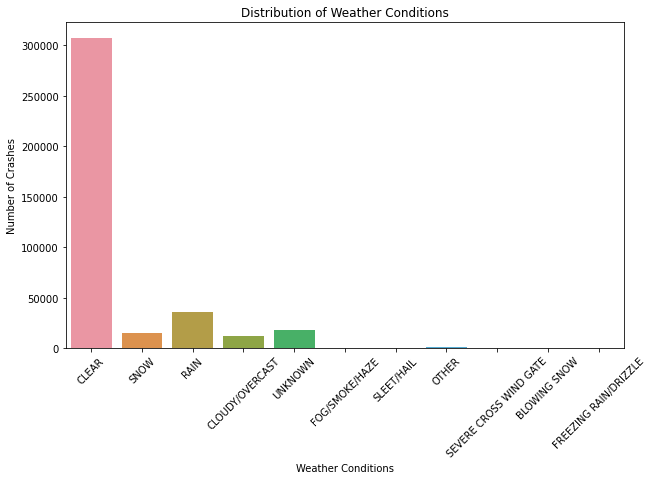

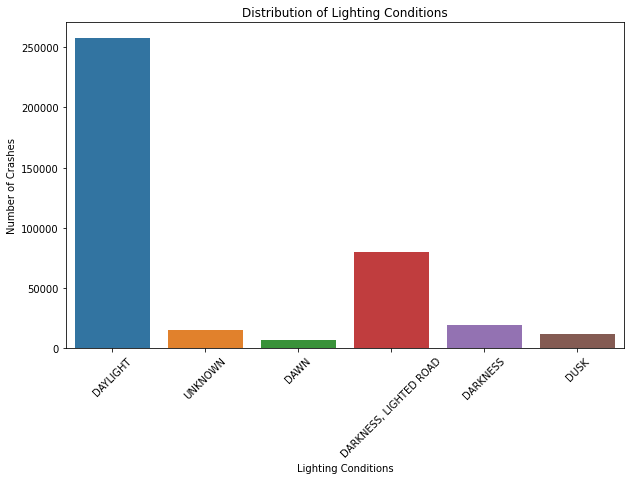

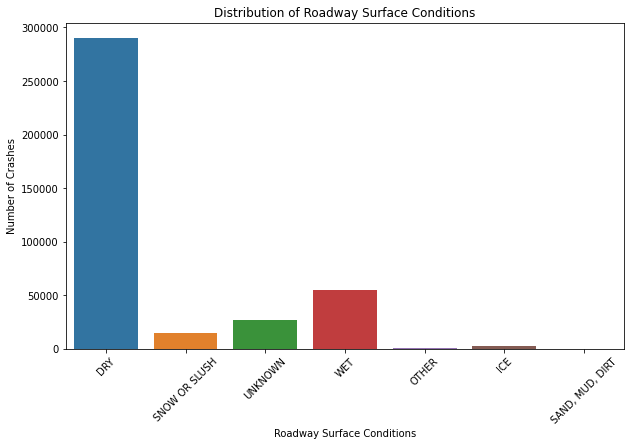

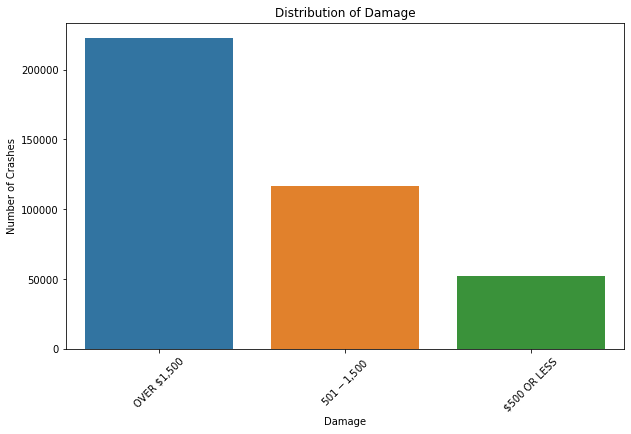

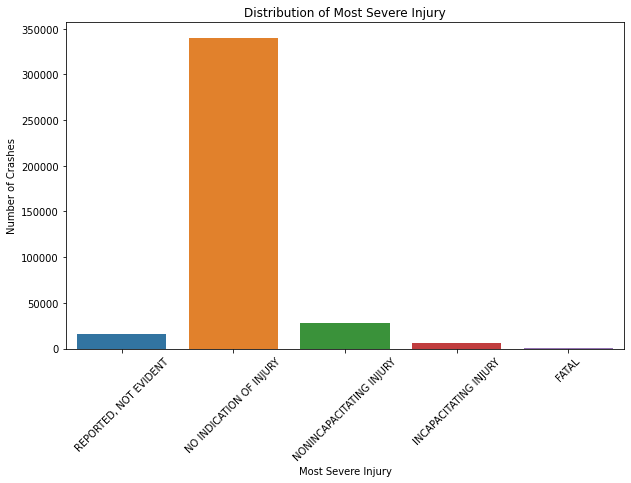

In [151]:
# Countplot for 'WEATHER_CONDITION'
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'WEATHER_CONDITION', dodge = True)
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Number of Crashes')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'LIGHTING_CONDITION' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'LIGHTING_CONDITION', dodge = True)
plt.title('Distribution of Lighting Conditions')
plt.xlabel('Lighting Conditions')
plt.ylabel('Number of Crashes')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'ROADWAY_SURFACE_COND' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'ROADWAY_SURFACE_COND', dodge = True)
plt.title('Distribution of Roadway Surface Conditions')
plt.xlabel('Roadway Surface Conditions')
plt.ylabel('Number of Crashes')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'DAMAGE' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'DAMAGE', dodge = True)
plt.title('Distribution of Damage')
plt.xlabel('Damage')
plt.ylabel('Number of Crashes')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'MOST_SEVERE_INJURY' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'MOST_SEVERE_INJURY', dodge = True)
plt.title('Distribution of Most Severe Injury')
plt.xlabel('Most Severe Injury')
plt.ylabel('Number of Crashes')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

### Make countplots for the UNIQUE values of each discrete numerical column.

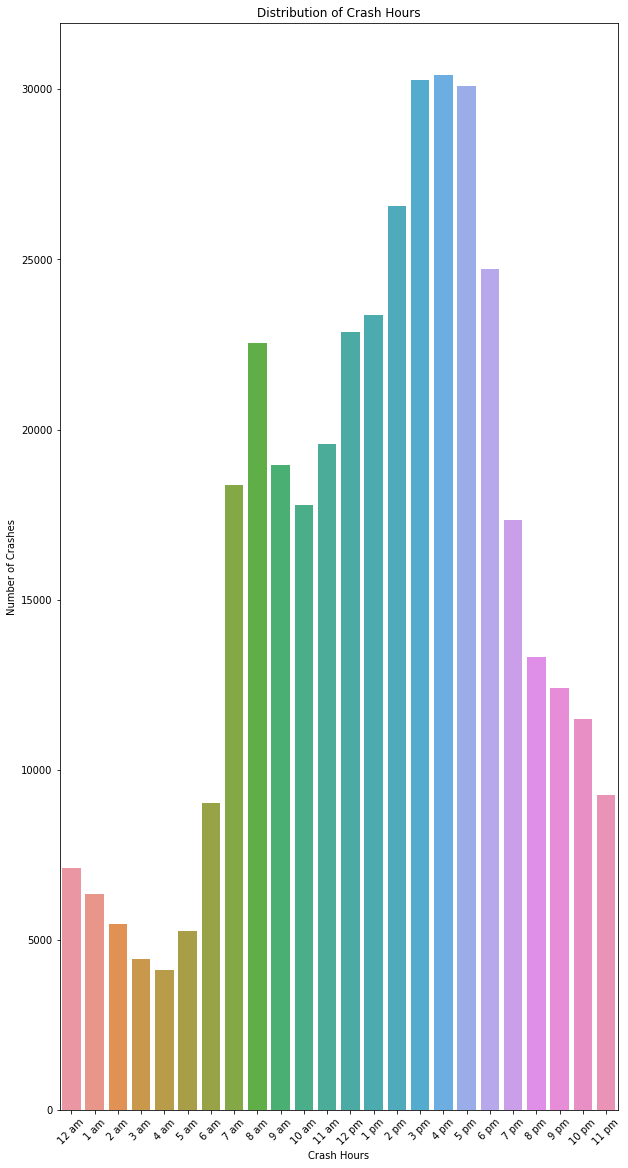

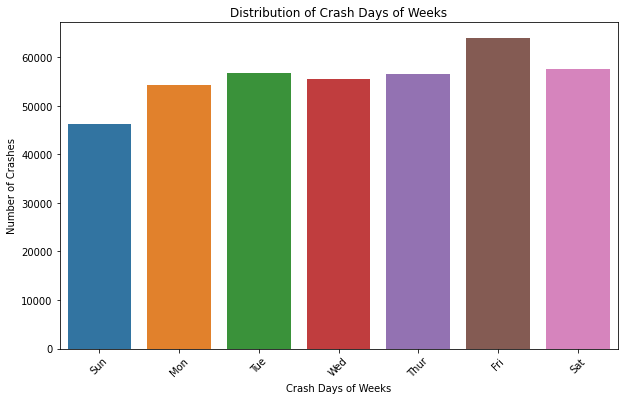

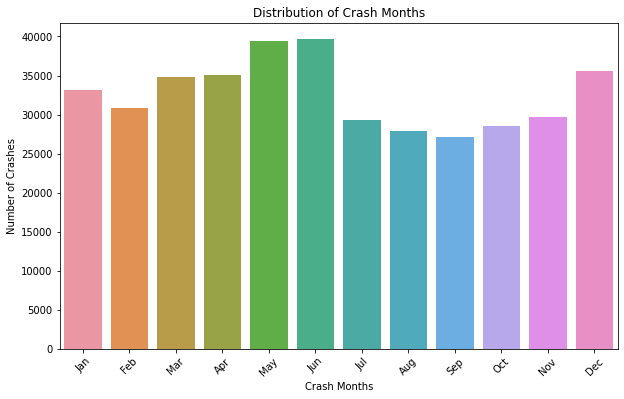

In [152]:
# Countplot for 'CRASH_HOUR'
plt.figure(figsize = (10, 20))
sns.countplot(data = df, x = 'CRASH_HOUR', dodge = True)
plt.title('Distribution of Crash Hours')
plt.xlabel('Crash Hours')
plt.ylabel('Number of Crashes')
plt.xticks(range(24), ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am',
                       '8 am', '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm',
                       '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_DAY_OF_WEEK' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'CRASH_DAY_OF_WEEK', dodge = True)
plt.title('Distribution of Crash Days of Weeks')
plt.xlabel('Crash Days of Weeks')
plt.ylabel('Number of Crashes')
plt.xticks(range(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_MONTH' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'CRASH_MONTH', dodge = True)
plt.title('Distribution of Crash Months')
plt.xlabel('Crash Months')
plt.ylabel('Number of Crashes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

The groupby() function below indicates the exact numeric distribution for the graph above depicting categories for the MOST_SEVERE_INJURY column.

In [153]:
grouped = df.groupby('MOST_SEVERE_INJURY')
count_per_group = grouped.size()
print(count_per_group)

MOST_SEVERE_INJURY
FATAL                          346
INCAPACITATING INJURY         6624
NO INDICATION OF INJURY     339934
NONINCAPACITATING INJURY     28059
REPORTED, NOT EVIDENT        16261
dtype: int64


### Make heatmaps of cross-tabulation between every possible 'MOST_SEVERE_INJURY' column pair.

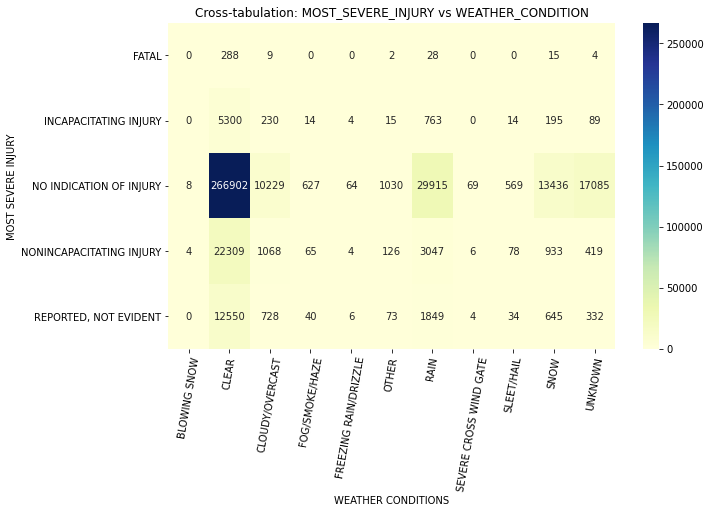

In [154]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'WEATHER_CONDITION'
cross_tab_severe_weather = pd.crosstab(df['MOST_SEVERE_INJURY'], df['WEATHER_CONDITION'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_weather, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs WEATHER_CONDITION")
plt.xlabel("WEATHER CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()


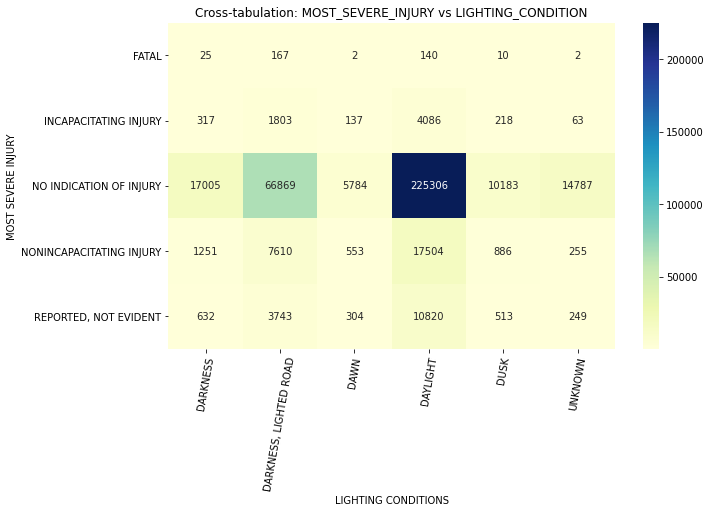

In [155]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'LIGHTING_CONDITION'
cross_tab_severe_lighting = pd.crosstab(df['MOST_SEVERE_INJURY'], df['LIGHTING_CONDITION'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_lighting, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs LIGHTING_CONDITION")
plt.xlabel("LIGHTING CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

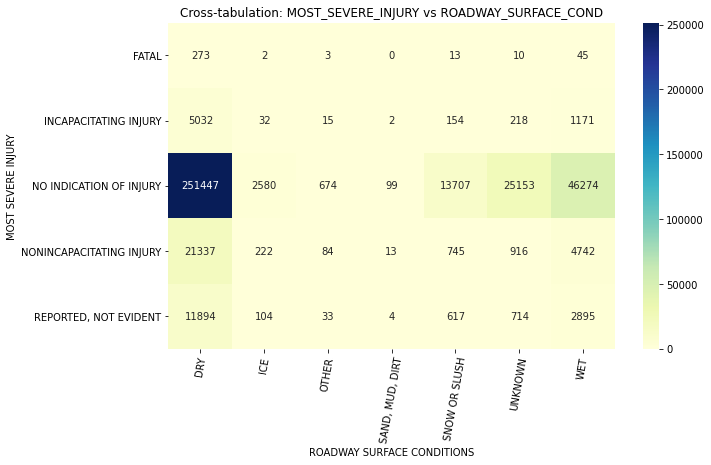

In [156]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'ROADWAY_SURFACE_COND'
cross_tab_severe_roadway = pd.crosstab(df['MOST_SEVERE_INJURY'], df['ROADWAY_SURFACE_COND'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_roadway, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs ROADWAY_SURFACE_COND")
plt.xlabel("ROADWAY SURFACE CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

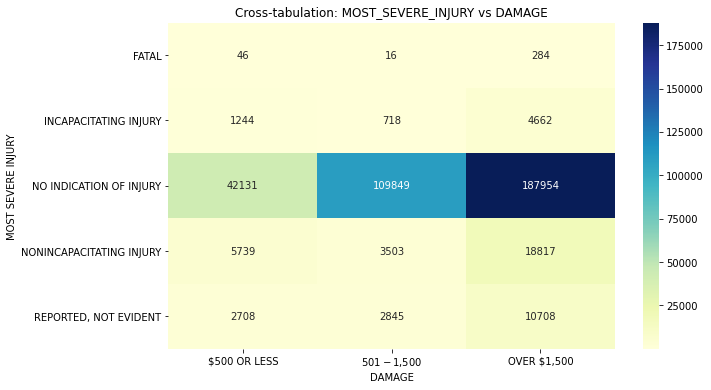

In [157]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'DAMAGE'
cross_tab_severe_damage = pd.crosstab(df['MOST_SEVERE_INJURY'], df['DAMAGE'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_damage, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs DAMAGE")
plt.xlabel("DAMAGE")
plt.ylabel("MOST SEVERE INJURY")
plt.show()

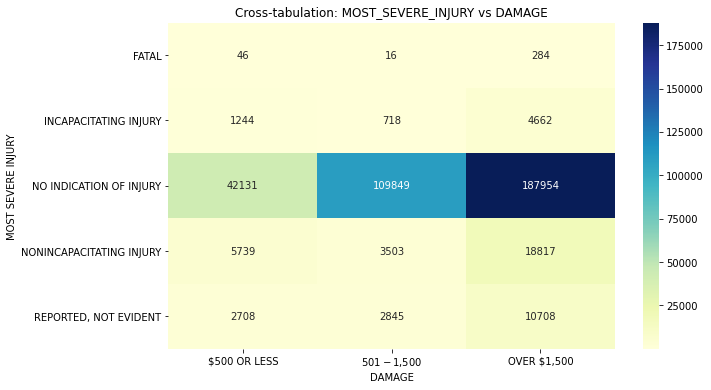

In [158]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'DAMAGE'
cross_tab_severe_damage = pd.crosstab(df['MOST_SEVERE_INJURY'], df['DAMAGE'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_damage, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs DAMAGE")
plt.xlabel("DAMAGE")
plt.ylabel("MOST SEVERE INJURY")
plt.show()

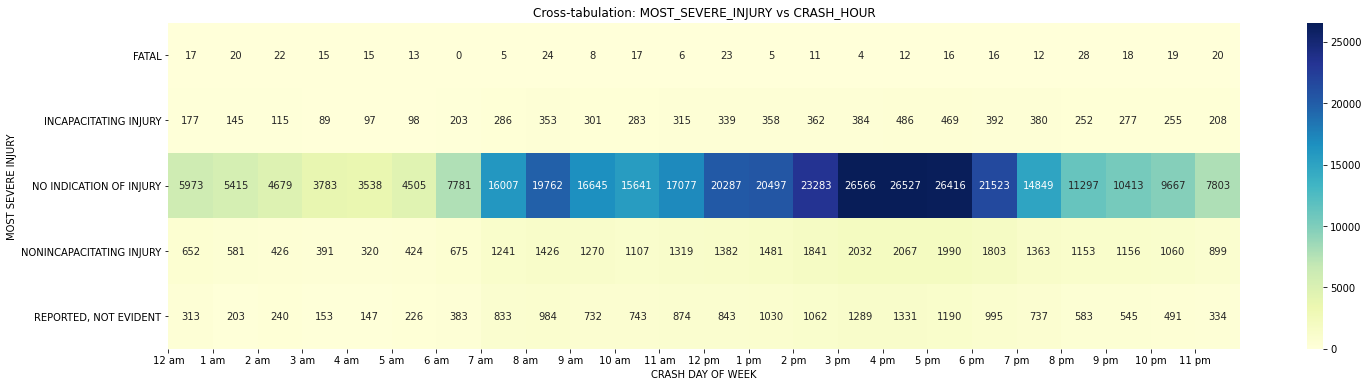

In [159]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'CRASH_HOUR'
cross_tab_severe_crash_hour = pd.crosstab(df['MOST_SEVERE_INJURY'], df['CRASH_HOUR'])
plt.figure(figsize=(24, 6))
sns.heatmap(cross_tab_severe_crash_hour, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs CRASH_HOUR")
plt.xlabel("CRASH DAY OF WEEK")
plt.ylabel("MOST SEVERE INJURY")
plt.xticks(range(24), ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am',
                       '8 am', '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm',
                       '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'])
plt.show()

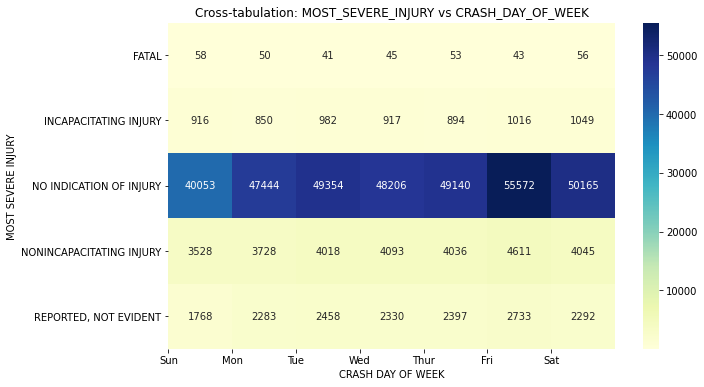

In [160]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'CRASH_DAY_OF_WEEK'
cross_tab_severe_crash_day_of_week = pd.crosstab(df['MOST_SEVERE_INJURY'], df['CRASH_DAY_OF_WEEK'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_severe_crash_day_of_week, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs CRASH_DAY_OF_WEEK")
plt.xlabel("CRASH DAY OF WEEK")
plt.ylabel("MOST SEVERE INJURY")
plt.xticks(range(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'])
plt.show()

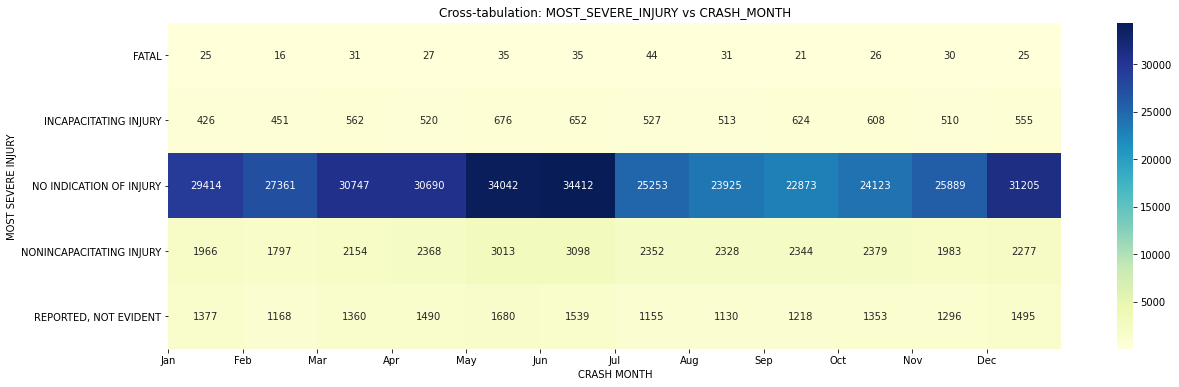

In [161]:

# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'CRASH_MONTH'
cross_tab_severe_crash_month = pd.crosstab(df['MOST_SEVERE_INJURY'], df['CRASH_MONTH'])
plt.figure(figsize=(20, 6))
sns.heatmap(cross_tab_severe_crash_month, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs CRASH_MONTH")
plt.xlabel("CRASH MONTH")
plt.ylabel("MOST SEVERE INJURY")
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# PRE-PROCESSING

### PERFORM ORDINAL ENCODING FOR SUITABLE CATEGORICAL COLUMNS.

In [162]:
# Define the desired order of categories
category_order = ['NO INDICATION OF INJURY', 'REPORTED, NOT EVIDENT', 'NONINCAPACITATING INJURY',
                  'INCAPACITATING INJURY', 'FATAL']

# Create an instance of the OrdinalEncoder with specified categories
ordinal_encoder = OrdinalEncoder(categories = [category_order])

# Perform ordinal encoding on the 'MOST_SEVERE_INJURY' column
encoded_values = ordinal_encoder.fit_transform(df[['MOST_SEVERE_INJURY']]) # <-- 

# Replace the original column with the encoded values
df['MOST_SEVERE_INJURY'] = encoded_values

# Print the updated DataFrame
print(df.head())

   Unnamed: 0 WEATHER_CONDITION LIGHTING_CONDITION ROADWAY_SURFACE_COND  \
0           0             CLEAR           DAYLIGHT                  DRY   
1           1             CLEAR           DAYLIGHT                  DRY   
2           2             CLEAR           DAYLIGHT                  DRY   
3           3             CLEAR           DAYLIGHT                  DRY   
4           4             CLEAR            UNKNOWN                  DRY   

        DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  MOST_SEVERE_INJURY  
0  OVER $1,500        14.0                2.0          3.0                 1.0  
1  OVER $1,500        14.0                2.0          3.0                 1.0  
2  OVER $1,500         8.0                4.0          9.0                 0.0  
3  OVER $1,500         8.0                4.0          9.0                 0.0  
4  OVER $1,500        17.0                1.0          6.0                 0.0  


In [163]:
# Define the desired order of categories
category_order = ['$500 OR LESS', '$501 - $1,500', 'OVER $1,500']

# Create an instance of the OrdinalEncoder with specified categories
ordinal_encoder = OrdinalEncoder(categories=[category_order])

# Perform ordinal encoding on the 'DAMAGE' column
encoded_values = ordinal_encoder.fit_transform(df[['DAMAGE']]) # <--

# Replace the original column with the encoded values
df['DAMAGE'] = encoded_values

# Print the updated DataFrame
print(df.head())


   Unnamed: 0 WEATHER_CONDITION LIGHTING_CONDITION ROADWAY_SURFACE_COND  \
0           0             CLEAR           DAYLIGHT                  DRY   
1           1             CLEAR           DAYLIGHT                  DRY   
2           2             CLEAR           DAYLIGHT                  DRY   
3           3             CLEAR           DAYLIGHT                  DRY   
4           4             CLEAR            UNKNOWN                  DRY   

   DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  MOST_SEVERE_INJURY  
0     2.0        14.0                2.0          3.0                 1.0  
1     2.0        14.0                2.0          3.0                 1.0  
2     2.0         8.0                4.0          9.0                 0.0  
3     2.0         8.0                4.0          9.0                 0.0  
4     2.0        17.0                1.0          6.0                 0.0  


### PERFORM ONE-HOT ENCODING FOR SUITABLE CATEGORICAL COLUMNS.

In [164]:
# Perform one-hot encoding on the 'WEATHER_CONDITION' column
encoded_df = pd.get_dummies(df['WEATHER_CONDITION'], prefix = 'WEATHER') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis = 1)

# Remove the original 'WEATHER_CONDITION' column
df.drop('WEATHER_CONDITION', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())

   Unnamed: 0 LIGHTING_CONDITION ROADWAY_SURFACE_COND  DAMAGE  CRASH_HOUR  \
0           0           DAYLIGHT                  DRY     2.0        14.0   
1           1           DAYLIGHT                  DRY     2.0        14.0   
2           2           DAYLIGHT                  DRY     2.0         8.0   
3           3           DAYLIGHT                  DRY     2.0         8.0   
4           4            UNKNOWN                  DRY     2.0        17.0   

   CRASH_DAY_OF_WEEK  CRASH_MONTH  MOST_SEVERE_INJURY  WEATHER_BLOWING SNOW  \
0                2.0          3.0                 1.0                 False   
1                2.0          3.0                 1.0                 False   
2                4.0          9.0                 0.0                 False   
3                4.0          9.0                 0.0                 False   
4                1.0          6.0                 0.0                 False   

   WEATHER_CLEAR  WEATHER_CLOUDY/OVERCAST  WEATHER_FOG/SMOKE/H

In [165]:
# Perform one-hot encoding on the 'LIGHTING_CONDITION' column
encoded_df = pd.get_dummies(df['LIGHTING_CONDITION'], prefix='LIGHTING') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Remove the original 'LIGHTING_CONDITION' column
df.drop('LIGHTING_CONDITION', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())

   Unnamed: 0 ROADWAY_SURFACE_COND  DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK  \
0           0                  DRY     2.0        14.0                2.0   
1           1                  DRY     2.0        14.0                2.0   
2           2                  DRY     2.0         8.0                4.0   
3           3                  DRY     2.0         8.0                4.0   
4           4                  DRY     2.0        17.0                1.0   

   CRASH_MONTH  MOST_SEVERE_INJURY  WEATHER_BLOWING SNOW  WEATHER_CLEAR  \
0          3.0                 1.0                 False           True   
1          3.0                 1.0                 False           True   
2          9.0                 0.0                 False           True   
3          9.0                 0.0                 False           True   
4          6.0                 0.0                 False           True   

   WEATHER_CLOUDY/OVERCAST  ...  WEATHER_SEVERE CROSS WIND GATE  \
0                  

In [166]:
# Perform one-hot encoding on the 'ROADWAY_SURFACE_COND' column
encoded_df = pd.get_dummies(df['ROADWAY_SURFACE_COND'], prefix='ROADWAY') # <--

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Remove the original 'ROADWAY_SURFACE_COND' column
df.drop('ROADWAY_SURFACE_COND', axis=1, inplace=True)

# Print the updated DataFrame
print(df.head())


   Unnamed: 0  DAMAGE  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  \
0           0     2.0        14.0                2.0          3.0   
1           1     2.0        14.0                2.0          3.0   
2           2     2.0         8.0                4.0          9.0   
3           3     2.0         8.0                4.0          9.0   
4           4     2.0        17.0                1.0          6.0   

   MOST_SEVERE_INJURY  WEATHER_BLOWING SNOW  WEATHER_CLEAR  \
0                 1.0                 False           True   
1                 1.0                 False           True   
2                 0.0                 False           True   
3                 0.0                 False           True   
4                 0.0                 False           True   

   WEATHER_CLOUDY/OVERCAST  WEATHER_FOG/SMOKE/HAZE  ...  LIGHTING_DAYLIGHT  \
0                    False                   False  ...               True   
1                    False                   False  ... 

### SPLIT DATA INTO TRAIN/TEST SETS.

In [167]:
# Split the features and target variable
X = df.drop('MOST_SEVERE_INJURY', axis=1)  # Features
y = df['MOST_SEVERE_INJURY']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

### PERFORM SMOTE TO ADDRESS CLASS IMBALANCE.

In [168]:
# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### APPLY A DUMMY CLASSIFIER AS THE BASELINE MODEL.

In [169]:
# Create an instance of the Dummy Classifier with the desired strategy
dummy_clf = DummyClassifier(strategy = 'most_frequent')

# Fit the Dummy Classifier to the training data
dummy_clf.fit(X_train, y_train)

# Generate predictions using the Dummy Classifier
y_pred = dummy_clf.predict(X_test)

# Evaluate the performance of the Dummy Classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8688995296844114
Precision: 0.8688995296844114
Recall: 0.8688995296844114
F1-Score: 0.8688995296844114


### APPLY A DECISION TREE MODEL.

In [170]:
# Create an instance of the DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

# Train the model on the oversampled training data
tree.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = tree.predict(X_test)

# Evaluate the model's performance using classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.9336872060527571
Precision: 0.935885648156185
Recall: 0.9336872060527571
F1-Score: 0.9346607320651645


### TUNE THE DECISION TREE HYPERPARAMETERS USING GRID SEARCH CROSS-VALIDATION.

In [171]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create an instance of the Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the performance of the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'micro') # Set the 'average' parameter equal to 'micro' bc the default is 'binary'.

# Print the evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.8689250903142254
Precision: 0.8689250903142254
Recall: 0.8689250903142254
F1-Score: 0.8689250903142254


### APPLY OPTIMAL HYPERPARAMETERS TO FINAL MODEL.

In [172]:
# Create the final model with the optimized hyperparameters
final_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split = 2)

# Train the final model on the entire training dataset
final_model.fit(X_train, y_train)

# Evaluate the performance of the final model on the test set
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8689250903142254
Precision: 0.788260421009006
Recall: 0.8689250903142254
F1-Score: 0.80802613073881


/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### APPLY A MULTINOMIAL LOGISTIC REGRESSION TREE MODEL.

In [173]:
# Create an instance of the LogisticRegression
logregmodel = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

# Train the model on the oversampled training data
logregmodel.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = logregmodel.predict(X_test)

# Evaluate the model's performance using classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.016929657146752097
Precision: 0.00028661329110657435
Recall: 0.016929657146752097
F1-Score: 0.0005636836119240319


/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### EXPLORE THE EFFECT OF DIFFERENT PENALTY VALUES ON MULTINOMIAL LOGISTIC REGRESSION MODELS.

In [176]:
# get a list of logistic regression models to evaluate
def get_logreg_models():
  models = dict()
  for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    # create name for model
    key = '%.4f' % p
    # turn off penalty in some cases
    if p == 0.0:
      # no penalty in this case
      models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, penalty='none')
    else:
      models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, penalty='l2', C=p)
  return models
  
# get the models to evaluate
logreg_models = get_logreg_models()

# evaluate the logistic regression
for name, model in logreg_models.items():
 
  # Train the model on the oversampled training data
  model.fit(X_train_smote, y_train_smote)

  # Make predictions on the testing data
  y_pred = model.predict(X_test)

  # Evaluate the model's performance using classification metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
  recall = recall_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
  f1 = f1_score(y_test, y_pred, average = 'weighted') # Set the 'average' parameter equal to 'weighted' bc the default is 'binary'.
 
  # Print the evaluation metrics
  print(f"Model with Penalty {name}: \nAccuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1-Score: {f1}\n")

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with Penalty 0.0000: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with Penalty 0.0001: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with Penalty 0.0010: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with Penalty 0.0100: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with Penalty 0.1000: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319

Model with Penalty 1.0000: 
Accuracy: 0.016929657146752097 
Precision: 0.00028661329110657435 
Recall: 0.016929657146752097 
F1-Score: 0.0005636836119240319



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
